<a href="https://colab.research.google.com/github/SumitraMukherjee/analytics/blob/master/SM_distribution_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distribution planning problem

Our objective is to ship items from *sources* with specified capacity via *warehouses* to meet specified demands at *destinations* at minimum cost, given costs of transshipment along the links.   

***Linear programming formulation of the distribution planning problem***:

**Parameters**:
- *SOURCES*: set of sources
- *DESTINATIONS*: set of destinations
- *WAREHOUSES*: set of warehouses
- $V = SOURCES \cup  DESTINATIONS$: terminal nodes
- $S[s]$: Maximum number of units that can be shipped out of source $s$, for $s \in SOURCES$
- $D[d]$: Minimum number of units that must be shipped into destination $d$, for $d \in DESTINATIONS$
- $C[w][v]$: Cost of shipping each unit along the link connecting warehouse $w$ and node $v$, for $w \in WAREHOUSES$ and $v \in V$

**Decision variables**:
- $X[w][v]$: Number of units shipped along the link connecting warehouse $w$ and node $v$, for $w \in WAREHOUSES$ and $v \in V$
- All decision variables are *non-negative*

**Objective function**:
$Minimize \ Cost = \sum_{w \in WAREHOUSES} \sum_{v \in V} (C[w][v] \times X[w][v])$

**Constraints**:
- Source capacity:  $\sum_{w \in WAREHOUSES} (X[w][s]) \le S[s]$ for $s \in SOURCES$
- Destination demand:  $\sum_{w \in WAREHOUSES} (X[w][d]) \le D[d]$ for $d \in DESTINATIONS$
- Warehouse conservation of flow: $\sum_{s \in SOURCES} (X[w][s]) - \sum_{d \in DESTINATIONS} (X[w][d]) = 0$ for $w \in WAREHOUSES$



## Install necessary packages
If needed packages are not pre-installed on Google Colab, we can install them 

In [1]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install pulp

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (59.4 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../libgeo

## Import libraries

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from pulp import * # for LP model
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Read problem data
- Read problem data from the file "*transshipment.csv*"
- File location: "*https://raw.githubusercontent.com/SumitraMukherjee/data/master/*"

Columns:
- *location*: name of location
- *longitude*, *latitude*: coordinatesof location
- *role*: type of location *source/warehouse/destination*
- *quantity*: capticity of source or demand at destination 

In [4]:
url = "https://raw.githubusercontent.com/SumitraMukherjee/analytics/master/"
filename = "transshipment.csv"
df = pd.read_csv(url+filename) # read data

# specify sources, warehouses, destination
SOURCES = df[df.role=='source'].location.tolist()
WAREHOUSES = df[df.role=='warehouse'].location.tolist()
DESTINATIONS = df[df.role=='destination'].location.tolist()

# create dictionary
lat = dict(zip(df.location, df.latitude)) # lat[c]: latitude of location c
long = dict(zip(df.location, df.longitude)) # long[c]: longitude of location c
qty = dict(zip(df.location, df.quantity)) # qty[c]: quantity for location c

# use basemap to transform lang, lat to x, y corrdinates for US
m = Basemap(projection='merc', lat_ts=0, resolution='i', suppress_ticks=True,
            llcrnrlon=-130, llcrnrlat=20, urcrnrlon=-60, urcrnrlat=50)

pos={v: m(long[v], lat[v]) for v in df.location} # xy coordinates of locations

# C[w][v]: transportation cost between warehouse w and source/destination v
C = {w:{v: euclidean(pos[w], pos[v])*0.0001 for v in SOURCES+DESTINATIONS}
     for w in WAREHOUSES}
print("\nCapacity at sources")
print(df[df.role=='source'][['location', 'quantity']])

print("\nShipped via:", ', '.join(WAREHOUSES))
print("\nDemand at destinations")
print(df[df.role=='destination'][['location', 'quantity']])


Capacity at sources
      location  quantity
0   Montgomery       700
1      Phoenix      1400
2  Little Rock      6700
3   Sacramento       600
4       Denver       600

Shipped via: Tallahassee, Atlanta, Boise, Springfield, Indianapolis, Des Moines, Topeka, Frankfort

Demand at destinations
          location  quantity
13     Baton Rouge       500
14         Augusta       500
15          Boston       200
16         Lansing       100
17      Saint Paul       100
18         Jackson       200
19  Jefferson City       100
20          Helana       600
21         Lincoln       300
22     Carson City       100
23         Concord       200
24        Santa Fe       500
25          Albany       600
26         Raleigh       100
27        Bismarck       200
28        Columbus       600
29   Oklahoma City       100
30           Salem       300
31      Harrisburg       400
32        Columbia       400
33          Pierre       200
34       Nashville       500
35          Austin       400
36  Salt 

## Display locations

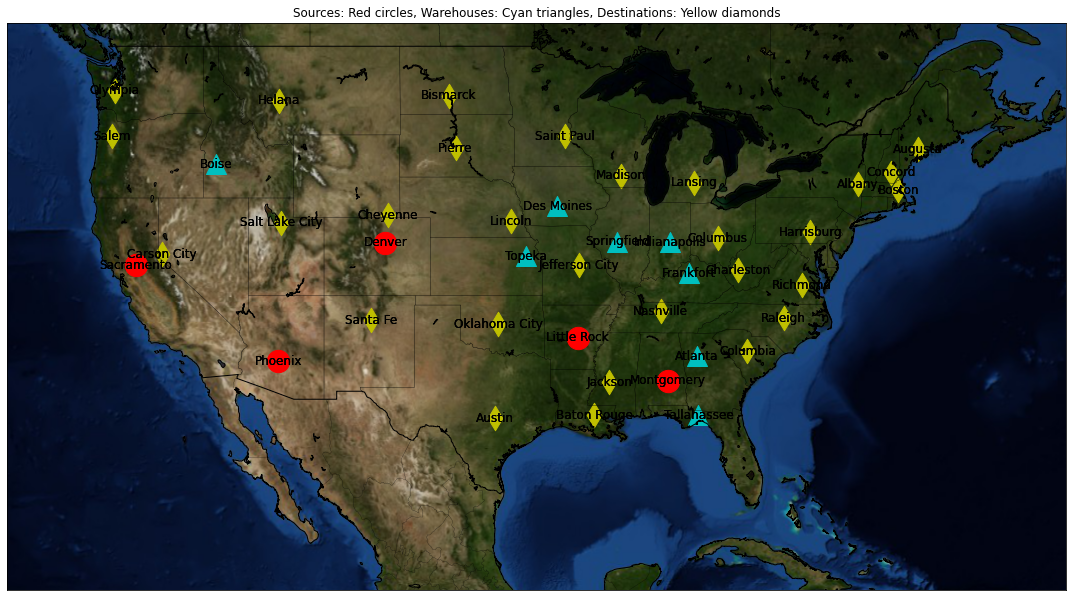

In [5]:
plt.figure(figsize = (15,15))

G=nx.DiGraph()
G.add_nodes_from(SOURCES+WAREHOUSES+DESTINATIONS) # add nodes

# draw network
nx.draw_networkx(G,pos, nodelist=SOURCES, node_size=500, node_color='r', node_shape='o')
nx.draw_networkx(G,pos,nodelist=WAREHOUSES,node_size=400, node_color='c', node_shape='^')
nx.draw_networkx(G,pos,nodelist=DESTINATIONS,node_size=300, node_color='y', node_shape='d')
# draw map
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
m.bluemarble()
plt.tight_layout()

plt.title('Sources: Red circles, Warehouses: Cyan triangles, Destinations: Yellow diamonds')
plt.show()

## Formulate Linear Programming model

In [6]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Transshipment_problem", LpMinimize)

# Define decision variables (variable name, lower limit)
X = {} # X[w][v] units shipped between warehouse w and terminal node v
for w in WAREHOUSES:
    X[w] = {}
    for v in SOURCES+DESTINATIONS:
        X[w][v] = LpVariable('.'.join(['X',w,v]), 0)


# Add objective function to 'prob' 
prob += lpSum(C[w][v]*X[w][v] for w in C for v in C[w]), "Total Cost"

# Add capacity constraint for each source
for s in SOURCES: 
    prob += lpSum(X[w][s] for w in C) <= qty[s], "Supply " + s

# Add demand constraint for each destination
for d in DESTINATIONS: 
    prob += lpSum(X[w][d] for w in C) >= qty[d], "Demand " + d

# Add conservation of flow constraint
for w in C:
    prob += lpSum(X[w][s] for s in SOURCES)-lpSum(X[w][d] for d in DESTINATIONS)==0, "Flow "+w 


## Solve model

In [7]:
prob.solve() # solve LP model
print("Status:", LpStatus[prob.status]) # optimal solution found?
print("Minimum cost = $ ", "{:2,}".format(round(value(prob.objective)))) # Cost
print()
print("Units shipped from sources to warehouses:")
for s in SOURCES:
    for w in C:
        x = X[w][s].varValue
        if x > 0:
            print("\t%d units shipped from %s to %s" %(x, s, w))
print("Units shipped from warehouses to destinations:")
for d in DESTINATIONS:
    for w in C:
        x = X[w][d].varValue
        if x > 0:
            print("\t%d units shipped from %s to %s" %(x, w, d))

Status: Optimal
Minimum cost = $  1,790,730

Units shipped from sources to warehouses:
	500 units shipped from Montgomery to Tallahassee
	200 units shipped from Montgomery to Atlanta
	1400 units shipped from Phoenix to Boise
	500 units shipped from Little Rock to Atlanta
	700 units shipped from Little Rock to Springfield
	100 units shipped from Little Rock to Indianapolis
	1500 units shipped from Little Rock to Topeka
	3900 units shipped from Little Rock to Frankfort
	600 units shipped from Sacramento to Boise
	100 units shipped from Denver to Des Moines
	500 units shipped from Denver to Topeka
Units shipped from warehouses to destinations:
	500 units shipped from Tallahassee to Baton Rouge
	500 units shipped from Frankfort to Augusta
	200 units shipped from Frankfort to Boston
	100 units shipped from Indianapolis to Lansing
	100 units shipped from Des Moines to Saint Paul
	200 units shipped from Atlanta to Jackson
	100 units shipped from Springfield to Jefferson City
	600 units shippe

## Display distribution network

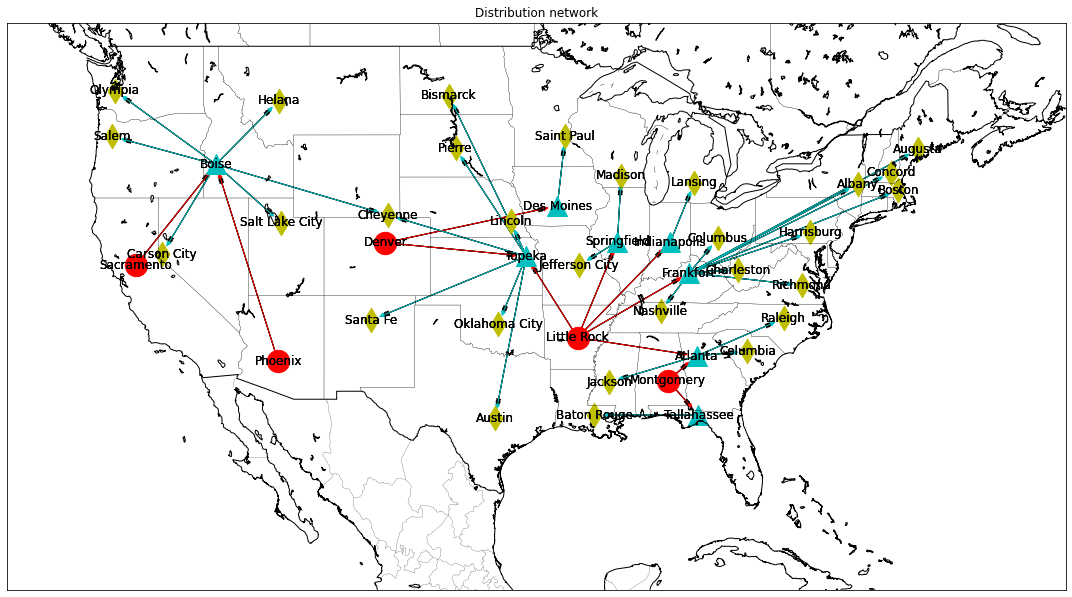

In [8]:
plt.figure(figsize = (15,15))

G=nx.DiGraph()
G.add_nodes_from(SOURCES+WAREHOUSES+DESTINATIONS) # add nodes

# shipment from sources to warehouses
for s in SOURCES:
    for w in WAREHOUSES:
        x = X[w][s].varValue
        if x > 0:
            G.add_edge(s,w, color='r')
# shipment from warehouses to destinations
for w in WAREHOUSES:
    for d in DESTINATIONS:
        x = X[w][d].varValue
        if x > 0:
            G.add_edge(w,d,color='c')

colors = [G[u][v]['color'] for u,v in G.edges()] # edge colors

# draw network
nx.draw_networkx(G,pos, nodelist=SOURCES, node_size=500, node_color='r', node_shape='o')
nx.draw_networkx(G,pos,nodelist=WAREHOUSES,node_size=400, node_color='c', node_shape='^')
nx.draw_networkx(G,pos,nodelist=DESTINATIONS,node_size=300, node_color='y', node_shape='d')
nx.draw_networkx_edges(G,pos,edge_color=colors)

# draw map
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)

plt.tight_layout()

plt.title('Distribution network')
plt.show()